<a href="https://colab.research.google.com/github/hyj765/AI-study/blob/main/DataSet_reuters_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
(x_train,y_train),(x_test,y_test)=reuters.load_data(num_words=1000,test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


In [5]:
print(max(y_train))
print(min(y_train))
print(x_train.shape)

45
0
(8982,)


In [11]:
X_train = pad_sequences(x_train,100)
X_test = pad_sequences(x_test,100)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [12]:
maxlen = 100
vocab_size = 1000
head = 2
embed_dim=32

In [13]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [14]:
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, head, embed_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(46, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 token_and_position_embeddin  (None, 100, 32)          35200     
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 100, 32)          10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy']
              )

In [ ]:
hist = model.fit(X_train,Y_train,epochs=30 , batch_size=32)

Epoch 1/30
281/281 [==============================] - 12s 36ms/step - loss: 2.2191 - accuracy: 0.4575
Epoch 2/30
281/281 [==============================] - 10s 36ms/step - loss: 1.6510 - accuracy: 0.5893
Epoch 3/30
281/281 [==============================] - 10s 35ms/step - loss: 1.4503 - accuracy: 0.6485
Epoch 4/30
281/281 [==============================] - 10s 36ms/step - loss: 1.3030 - accuracy: 0.6805
Epoch 5/30
281/281 [==============================] - 10s 36ms/step - loss: 1.1978 - accuracy: 0.7029
Epoch 6/30
281/281 [==============================] - 10s 37ms/step - loss: 1.1405 - accuracy: 0.7182
Epoch 7/30
281/281 [==============================] - 10s 36ms/step - loss: 1.0893 - accuracy: 0.7256
Epoch 8/30
281/281 [==============================] - 10s 36ms/step - loss: 1.0498 - accuracy: 0.7368
Epoch 9/30
281/281 [==============================] - 10s 36ms/step - loss: 1.0017 - accuracy: 0.7477
Epoch 10/30
281/281 [==============================] - 10s 36ms/step - loss: 0.975

In [ ]:
model.evaluate(X_test,Y_test)

71/71 [==============================] - 1s 16ms/step - loss: 1.5523 - accuracy: 0.7079


[1.552331805229187, 0.7079252004623413]

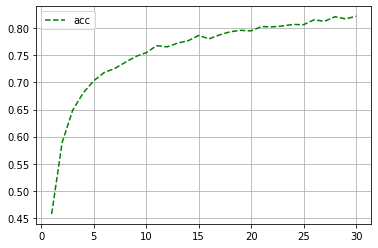

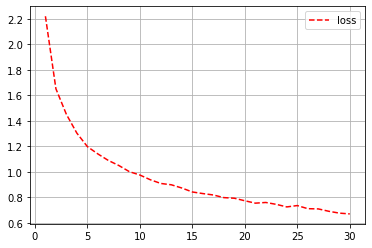

In [ ]:
acc = hist.history['accuracy']
loss=hist.history['loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc,'g--',label = "acc")
plt.grid()
plt.legend()
plt.figure()
plt.plot(epochs,loss,'r--',label = "loss")
plt.grid()
plt.legend()
plt.show()